Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)
# PyTorch Lightning Tutorial


This tutorial demonstrates how MONAI can be used in conjunction with PyTorch Lightning framework to construct a training workflow of UNETR on multi-organ segmentation task using the BTCV challenge dataset.

![image](../figures/btcv_transformer.png)

And it contains the following features:
1. Transforms for dictionary format data.
2. Define a new transform according to MONAI transform API.
3. Load Nifti image with metadata, load a list of images and stack them.
4. Randomly adjust intensity for data augmentation.
5. Cache IO and transforms to accelerate training and validation.
6. 3D UNETR model, Dice loss function, Mean Dice metric for multi-oorgan segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kidney 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](../figures/BTCV_organs.png)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d_lightning.ipynb)

## Setup environment

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[nibabel, einops]"
#!pip install -q pytorch-lightning~=2.0
#!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import shutil
import tempfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import json

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
)

import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from unetr.utilsUnetr.transforms import ResizeOrDoNothingd

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 0.7.0
Numpy version: 1.23.4
Pytorch version: 2.0.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.15.1
gdown version: 4.7.1
TorchVision version: 0.10.1
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.3
pandas version: 1.5.1
einops version: 0.5.0
transformers version: 4.38.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
torch.cuda.device_count()

0

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = './'
print(root_dir)

./


# Train test split

In [4]:
base_dir = "dataset/"
img_paths = []
mask_paths = []

for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)
    
    img_path = os.path.join(patient_path, "image.nii.gz")
    mask_path = os.path.join(patient_path, "mask_meta.nii.gz")
    
    if os.path.exists(img_path) and os.path.exists(mask_path):
        img_paths.append(img_path)
        mask_paths.append(mask_path)    
    
    
train_img_paths, temp_img_paths, train_mask_paths, temp_mask_paths = train_test_split(img_paths, mask_paths, test_size=0.2, random_state=42)

# Redivision de la validation et du test en deux parties

val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(temp_img_paths, temp_mask_paths, test_size=0.5, random_state=42)


print(len(train_img_paths))
print(len(val_img_paths))
print(len(test_img_paths))

    

7
1
1


In [5]:
data_split = {
    "training" : {"image" : train_img_paths, "label" : train_mask_paths},
    "validation" : {"image" : val_img_paths, "label" : val_mask_paths},
    "test" : {"image" : test_img_paths, "label" : test_mask_paths}
}

json_output = "./dataset/dataset_us.json"

with open(json_output, "w") as json_file : 
    json.dump(data_split, json_file, indent=4)
    


## Define the LightningModule (transform, network)
The LightningModule contains a refactoring of your training code. The following module is a refactoring of the code in spleen_segmentation_3d.ipynb:

In [13]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()

        self._model = UNETR(
            in_channels=1,
            out_channels=6,
            img_size=(96, 96, 96),
            feature_size=16,
            hidden_size=768,
            mlp_dim=3072,
            num_heads=12,
            pos_embed="perceptron",
            norm_name="instance",
            res_block=True,
            conv_block=True,
            dropout_rate=0.0,
        ).to(device)

        self.loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
        #self.post_pred = AsDiscrete(argmax=True, to_onehot=14)
        #self.post_label = AsDiscrete(to_onehot=14)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=True, num_classes=6)
        self.post_label = AsDiscrete(to_onehot=True, num_classes=6)

        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.max_epochs =30
        self.check_val = 30
        self.warmup_epochs = 20
        self.metric_values = []
        self.epoch_loss_values = []
        self.validation_step_outputs = []

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # prepare data
        #data_dir = "./dataset/"
        #split_json = "dataset_us.json"
        #datasets = data_dir + split_json
        #datalist = load_decathlon_datalist(datasets, True, "training")
        #val_files = load_decathlon_datalist(datasets, True, "validation")

        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                ScaleIntensityRanged(
                    keys=["image"],
                    # a_min=-175,
                    a_min = -200,
                    a_max=300,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[0],
                    prob=0.10,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[1],
                    prob=0.10,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[2],
                    prob=0.10,
                ),
                RandRotate90d(
                    keys=["image", "label"],
                    prob=0.10,
                    max_k=3,
                ),
                RandShiftIntensityd(
                    keys=["image"],
                    offsets=0.10,
                    prob=0.50,
                ),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-175,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                ResizeOrDoNothingd(keys=["image", "label"], max_spatial_size=(342, 342, 104)), # ramène l'image à la taille maximale acceptée par le modèle
                #ResizeOrDoNothingd(keys=["image", "label"], max_spatial_size=(400, 400, 96))
                #ResizeOrDoNothingd(keys=["image", "label"], max_spatial_size=(16, 16, 16))
            ]
        )

        self.train_ds = CacheDataset(
            data= [{'image' : img, "label": lbl} for img, lbl in zip(data_split['training']['image'], data_split['training']['label'])],
            transform=train_transforms,
            cache_num=24,
            cache_rate=1.0,
            num_workers=8,
        )
        self.val_ds = CacheDataset(
            data= [{'image' : img, "label": lbl} for img, lbl in zip(data_split['validation']['image'], data_split['validation']['label'])],
            transform=val_transforms,
            cache_num=6,
            cache_rate=1.0,
            num_workers=8,
        )

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=1,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = (batch["image"], batch["label"])
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        
        # log val loss for modelcheckpoint to monitor
        self.log('val_loss', mean_val_loss, on_epoch=True, prog_bar=True, logger=True)
        
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
    
        self.metric_values.append(mean_val_dice)
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}

In [7]:
print(device)

cpu


## Run the training

In [8]:
# # initialise the LightningModule
# net = Net()


# # set up checkpoints
# checkpoint_callback = ModelCheckpoint(
#     filename="best_checkpoint",
#     monitor="val_loss",
#     mode="min",
#     save_top_k=-1,
#     save_last=True,
#     verbose=True
# )

#  # initialise Lightning's trainer.
# trainer = pytorch_lightning.Trainer(
#     accelerator='gpu',
#     devices=1,
#     max_epochs=net.max_epochs,
#     check_val_every_n_epoch=net.check_val,
#     callbacks=checkpoint_callback,
#     default_root_dir=root_dir,
#  )

# # # train
# trainer.fit(net)
# torch.save(net.state_dict(),"model.ckpt")

### Plot the loss and metric

In [9]:
# eval_num = 250
# plt.figure("train", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Iteration Average Loss")
# x = [eval_num * (i + 1) for i in range(len(net.epoch_loss_values))]
# y = net.epoch_loss_values
# plt.xlabel("Iteration")
# plt.plot(x, y)
# plt.subplot(1, 2, 2)
# plt.title("Val Mean Dice")
# x = [eval_num * (i + 1) for i in range(len(net.metric_values))]
# y = net.metric_values
# plt.xlabel("Iteration")
# plt.plot(x, y)
# plt.show()

### Check best model output with the input image and label

In [14]:
net = Net()

slice_map = {
        # "dataset/201709127/image.nii.gz" : 28.899,
        # "dataset/201704321/image.nii.gz" : 31.706,
        # "dataset/201709668/image.nii.gz" : 41.868,
        # "dataset/201705956/image.nii.gz" : 54.147,
        "image.nii.gz" : 20,
        # "dataset/201708552/image.nii.gz" : 47.003,
        # "dataset/201707259/image.nii.gz" : 56.608,
        # "dataset/201709600/image.nii.gz" : 26.502,
        # "dataset/201705438/image.nii.gz" : 9.831,
        # "dataset/201709795/image.nii.gz" : 29.178,
}
case_num = 0
net.load_from_checkpoint(os.path.join(root_dir, "best_checkpoint.ckpt"))
net.eval()
net.to(device)
net.prepare_data()

with torch.no_grad():
        img_name = os.path.split(net.val_ds[case_num]['image_meta_dict']['filename_or_obj'])[-1]
        img = net.val_ds[case_num]["image"]
        label = net.val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(torch.from_numpy(img), 1).to(device)
        print(val_inputs.shape)
        val_labels = torch.unsqueeze(torch.from_numpy(img), 1).to(device)
        print(val_labels.shape)
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.subplot(1, 3, 3)
        val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, net, overlap=0.8)
        print(val_outputs.shape)
        plt.title("output")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.show()


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [23]:
import torch

# Chemin vers votre fichier checkpoint
checkpoint_path = './best_checkpoint.ckpt'

# Charger le checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Afficher les clés du checkpoint pour comprendre son contenu
print(checkpoint.keys())

# Vous pouvez aussi imprimer le contenu spécifique pour une clé donnée
# Par exemple, pour imprimer l'état de l'optimiseur (si présent)
if 'optimizer_state_dict' in checkpoint:
    print(checkpoint['optimizer_state_dict'])

# Ou pour l'état du modèle
if 'state_dict' in checkpoint:
    print(checkpoint['state_dict'])

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
OrderedDict([('_model.vit.patch_embedding.position_embeddings', tensor([[[ 0.0238,  0.0174,  0.0097,  ..., -0.0056, -0.0415,  0.0126],
         [-0.0036,  0.0025,  0.0016,  ..., -0.0356, -0.0076,  0.0478],
         [ 0.0181, -0.0099, -0.0347,  ..., -0.0074,  0.0066, -0.0064],
         ...,
         [ 0.0008, -0.0022, -0.0143,  ..., -0.0011, -0.0298, -0.0219],
         [ 0.0238, -0.0241,  0.0214,  ..., -0.0192, -0.0057,  0.0019],
         [-0.0574,  0.0034,  0.0272,  ..., -0.0206,  0.0004, -0.0046]]])), ('_model.vit.patch_embedding.cls_token', tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [ ]:
import numpy as np
val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, net, overlap=0.8)

np.unique(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]].numpy())

: 

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
img_name = os.path.split(net.val_ds[case_num]['label_meta_dict']['filename_or_obj'])[-1]
print(img_name)

label0039.nii.gz


In [ ]:
net

Net(
  (_model): UNETR(
    (vit): ViT(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Sequential(
          (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
          (1): Linear(in_features=4096, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (blocks): ModuleList(
        (0): TransformerBlock(
          (mlp): MLPBlock(
            (linear1): Linear(in_features=768, out_features=3072, bias=True)
            (linear2): Linear(in_features=3072, out_features=768, bias=True)
            (fn): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): SABlock(
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (qkv): Linear(in_features=768, out_features=2304, bias=False)
        

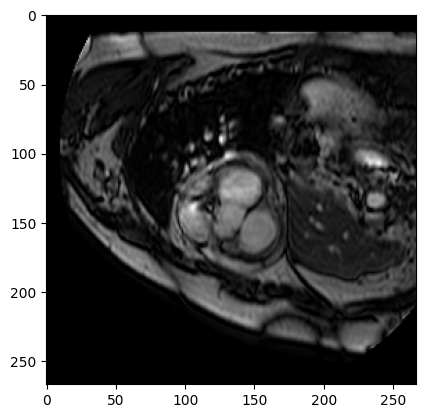

In [ ]:
plt.imshow(val_inputs.numpy()[0, 0, :, ::-1 , -1].T, cmap='gray')

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)